# Clustering

In [1]:
import os
from pathlib import Path

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


import sklearn
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

from kneed import KneeLocator

from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist

# Setting random seed
np.random.seed(54)

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(suppress=True)  #<- suppress scientific notations

In [4]:
data_dir = 'Data'
data_files = os.listdir(data_dir)

target_files = [x for x in data_files if 'df_' in x]
output_dir = data_dir+'/cluster_data_files'


try:
    if output_dir in os.listdir():
        print(True)
    else:
        os.mkdir(output_dir)
except:
    print('Folder exists')
    

Folder exists


In [5]:
target_file_number = 2
subset_columns = ['percent_change','open', 'close', 'low', 'high', 'volume', 'n_trades',
       'compound_avg','nTweets','nlikes','nreplies','nretweets']
distance_metric = 'cosine'

In [6]:
df = pd.read_csv(data_dir+'/'+target_files[2]).drop('Unnamed: 0',axis = 1)
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [7]:
df.columns

Index(['date', 'open', 'close', 'low', 'high', 'volume', 'n_trades',
       'compound_avg', 'compound_scaled_avg', 'price_change', 'percent_change',
       'code', 'nTweets', 'nlikes', 'nreplies', 'nretweets',
       'k_means_clusters', 'hier_clusters', 'db_clusters'],
      dtype='object')

In [8]:
def cluster_scaler(target_file_number,data_dir,target_files,subset_columns,scale):
    
    df = pd.read_csv(data_dir+'/'+target_files[target_file_number]).drop('Unnamed: 0',axis = 1)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    if scale == 'minmax':
        scaler = MinMaxScaler()
    if scale == 'standard':
        scaler = StandardScaler()
        
    scaled_data = scaler.fit_transform(df[subset_columns])
    df_scaled = pd.DataFrame(scaled_data, columns = subset_columns)
    df_scaled = pd.concat([df[['date']],df_scaled],axis = 1).set_index('date')
            
    return df_scaled

## K-Means Clustering

Importing libraries

In [9]:
df_kmeans = cluster_scaler(2,data_dir,target_files,subset_columns,'minmax')
#scatter_matrix(df_kmeans,figsize = (20,20),diagonal='kde')
#plt.show()
#plt.close()

In [10]:
def make_k_means(df,clusters):
    kmeans_val = KMeans(n_clusters=clusters)
    kmeans_val = kmeans_val.fit(df)
    labels = kmeans_val.predict(df)
    C_val = kmeans_val.cluster_centers_
    return kmeans_val, C_val, labels

In [11]:
def plot_clusters(df,k_means,centroid,x,y,size,labels):
    
    xlabel = df.columns[x]

    ylabel = df.columns[y]

    size_label = df.columns[size]
    
    fig,ax = plt.subplots(figsize = (10,10))

    
    plt.scatter(
        df.iloc[:,x], 
        df.iloc[:,y], 
        c=k_means.labels_, s = 500*df[size_label], alpha = 0.6, edgecolor = 'black',
        cmap='rainbow')
    
    if centroid is not 0:
        plt.scatter(
            centroid[:, x],
            centroid[:, y],
            c='black', edgecolor = 'white',
            s=200,
            alpha=1)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


    plt.show()
    plt.close()
    

<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/bx/98s7l1y96p1f_2n55v3g_3dc0000gn/T/ipykernel_47629/1121461236.py:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if centroid is not 0:


In [12]:
def elbow_plot(KK, betweenss, totss):
    clr = cm.Spectral( np.linspace(0,1,10) ).tolist()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(KK, betweenss/totss*100, 'b*-')
    ax.set_ylim((0,100))
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    plt.close()
    
    kl = KneeLocator(x = KK, y = betweenss/totss*100,
                 curve = 'concave', 
                 direction = 'increasing', 
                 S = 1)
    kl.plot_knee()
    elbow_cluster = kl.knee
    print(elbow_cluster)
    
    return elbow_cluster



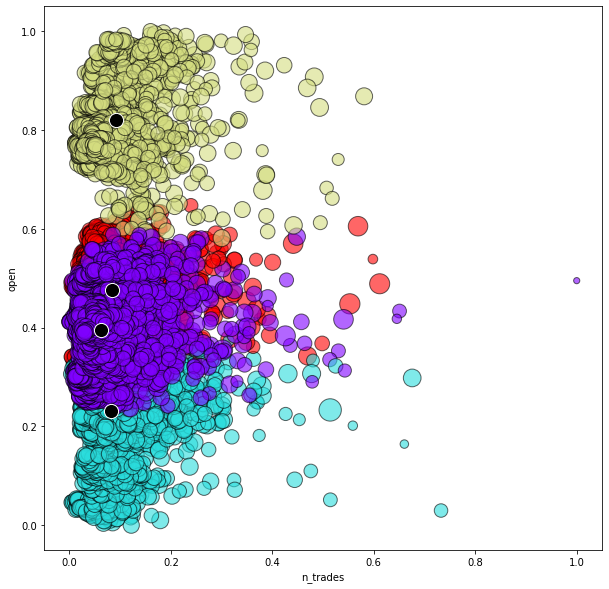

In [13]:
kmeans_default, C_default, labels = make_k_means(df_kmeans,4)
df_kmeans['k_means_clusters'] = np.array(labels)
plot_clusters(df_kmeans,kmeans_default,C_default,6,1,0,np.array(labels))

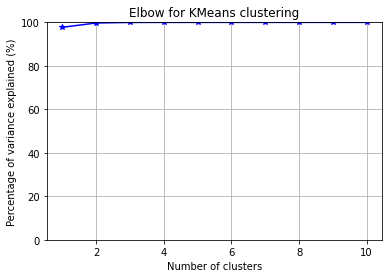

3


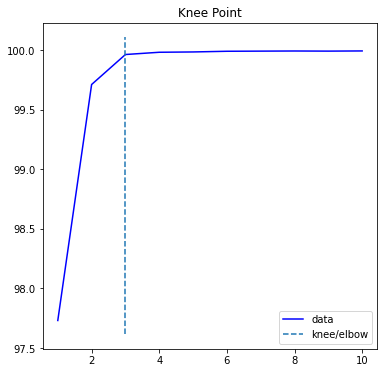

In [14]:
K_MAX = 10
KK = range(1, K_MAX+1)
KM = [kmeans(df_kmeans,k) for k in KK]

centroids = [cent for (cent,var) in KM]

# Calculate centroids for each iteration of k. 
D_k = [cdist(df_kmeans, cent, distance_metric) for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]              # Total within-cluster sum of squares
totss = sum(pdist(df_kmeans)**2)/df_kmeans.shape[0]   # The total sum of squares
betweenss = totss - tot_withinss                      # The between-cluster sum of squares

elbow_cluster = elbow_plot(KK, betweenss, totss)

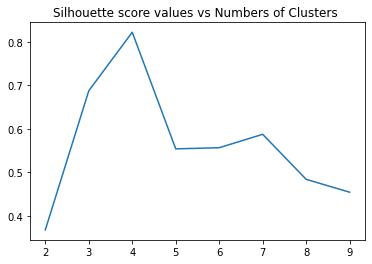

Optimal number of components is: 4


In [15]:
obs = df_kmeans
silhouette_score_values = list()
NumberOfClusters = range(2, K_MAX)

for i in NumberOfClusters:
    classifier = KMeans(i,
                                init = 'k-means++', 
                                n_init = 10, 
                                max_iter = 300, 
                                tol = 0.0001, 
                                verbose = 0, 
                                random_state = None, 
                                copy_x = True)
    classifier.fit(obs)
    labels= classifier.predict(obs)
    sklearn.metrics.silhouette_score(obs,
                                     labels,
                                     metric = distance_metric, 
                                     sample_size = None, 
                                     random_state = None)
    silhouette_score_values.append(sklearn.metrics.silhouette_score(
                                    obs,
                                    labels,
                                    metric = distance_metric, 
                                    sample_size = None,
                                    random_state = None))

plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
plt.close()

sil_cluster = NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:", sil_cluster)


In [16]:
optimal_clusters = min(elbow_cluster, sil_cluster)
print(optimal_clusters)

# Explained variance for default number of clusters.
print(betweenss[4 - 1]/totss * 100)
# Explained variance for optimal number of clusters.
print(betweenss[optimal_clusters - 1]/totss * 100)

3
99.98111051030183
99.96227394882851


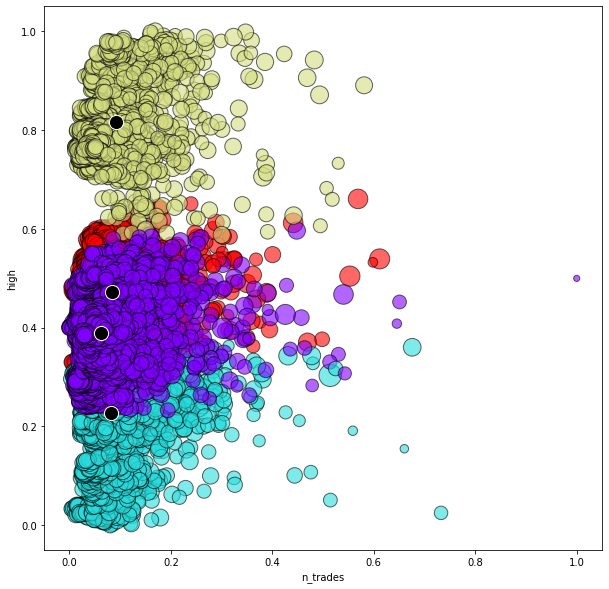

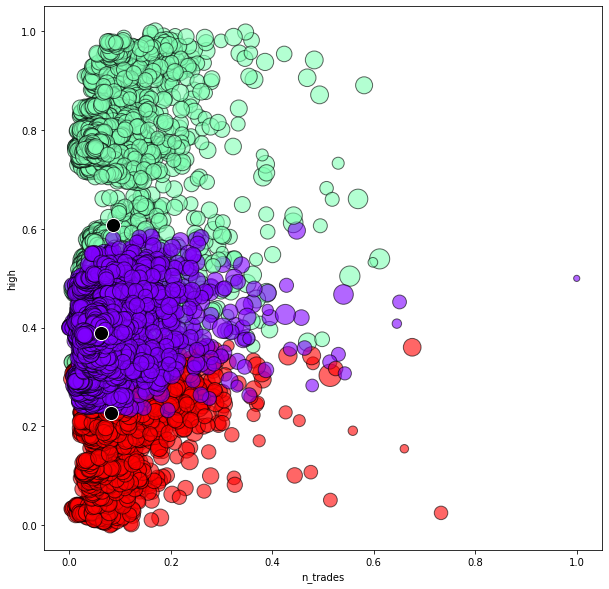

In [17]:
kmeans_optimal, C_optimal, labels_optimal = make_k_means(df_kmeans,optimal_clusters)
df_kmeans['k_means_optimal_cluster'] = np.array(labels_optimal)
plot_clusters(df_kmeans,kmeans_default,C_default,6,4,0,np.array(labels))
plot_clusters(df_kmeans,kmeans_optimal,C_optimal,6,4,0,np.array(labels_optimal))

<Figure size 432x288 with 0 Axes>

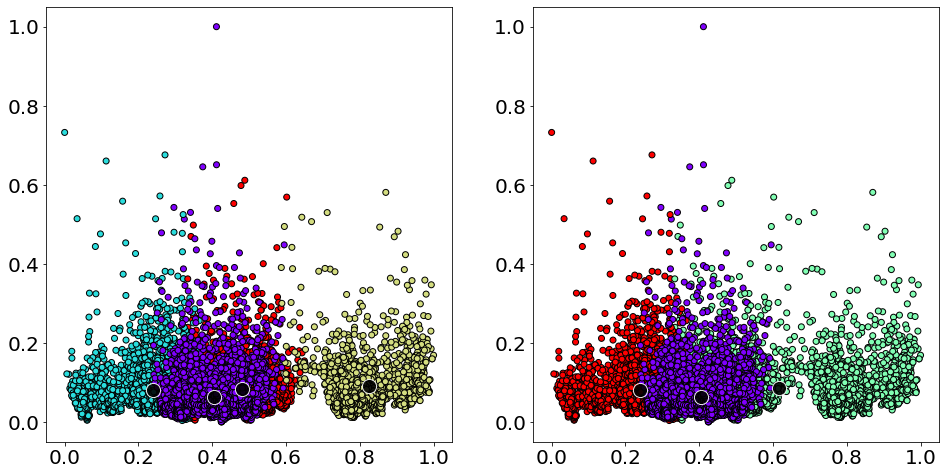

In [18]:
x = 3
y = 6
plt.clf()
plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.scatter(df_kmeans.iloc[:,x],df_kmeans.iloc[:,y],c=df_kmeans['k_means_clusters'],cmap='rainbow', edgecolor = 'black')
plt.scatter(C_default[:, x], C_default[:, y], c='black', s=200,alpha=0.9, edgecolor = 'white')

plt.subplot(1, 2, 2)
plt.scatter(df_kmeans.iloc[:,x],df_kmeans.iloc[:,y], c=df_kmeans['k_means_optimal_cluster'], cmap='rainbow', edgecolor = 'black')
plt.scatter(C_optimal[:, x], C_optimal[:, y], c='black', s=200, alpha=0.9, edgecolor = 'white')

In [19]:
df_kmeans.groupby('k_means_optimal_cluster').mean().sort_values('percent_change')

,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets,k_means_clusters
k_means_optimal_cluster,,,,,,,,,,,,,
1,0.491232,0.611917,0.611839,0.617325,0.608260,0.452731,0.086737,0.520955,0.101658,0.012449,0.020405,0.008454,2.603208
2,0.491287,0.231639,0.231771,0.238738,0.226400,0.286327,0.081046,0.508041,0.092844,0.011309,0.018012,0.007987,1.000000
0,0.491667,0.395787,0.395873,0.404444,0.389017,0.691029,0.063086,0.520596,0.082754,0.010065,0.017522,0.007466,0.000000


In [20]:
del df_kmeans['k_means_clusters']

In [21]:
df_kmeans.to_csv(output_dir+'/'+'kmeans.csv')

## Hierarchical

In [22]:
df_hier = cluster_scaler(2,data_dir,target_files,subset_columns,'minmax')
df_dist = pdist(df_hier, distance_metric)
df_linked = linkage(df_dist, 'complete')


In [23]:
df_hier

,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets
date,,,,,,,,,,,,
2022-08-01 00:00:00,0.466102,0.476410,0.472078,0.472158,0.468500,0.0,0.155931,0.503256,0.307143,0.024358,0.087017,0.017734
2022-08-01 00:01:00,0.533898,0.475607,0.482696,0.473983,0.478375,0.0,0.113277,0.495549,0.089286,0.014950,0.013923,0.003018
2022-08-01 00:02:00,0.415254,0.482693,0.470989,0.475228,0.472269,0.0,0.087853,0.481539,0.075000,0.000930,0.000696,0.000126
2022-08-01 00:03:00,0.474576,0.469846,0.467594,0.473352,0.465035,0.0,0.068495,0.624172,0.078571,0.001785,0.006613,0.002012
2022-08-01 00:04:00,0.483051,0.465899,0.464597,0.473660,0.461508,0.0,0.053262,0.385437,0.082143,0.008293,0.012879,0.002767
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-09 23:55:00,0.500000,0.394267,0.395862,0.403258,0.386904,1.0,0.034296,0.775967,0.046429,0.000223,0.002785,0.000880
2022-08-09 23:56:00,0.483051,0.395351,0.393774,0.405972,0.386368,1.0,0.025315,0.604991,0.046429,0.001264,0.004177,0.000629
2022-08-09 23:57:00,0.474576,0.393672,0.390817,0.402856,0.382474,1.0,0.030732,0.630141,0.050000,0.000930,0.004177,0.000126


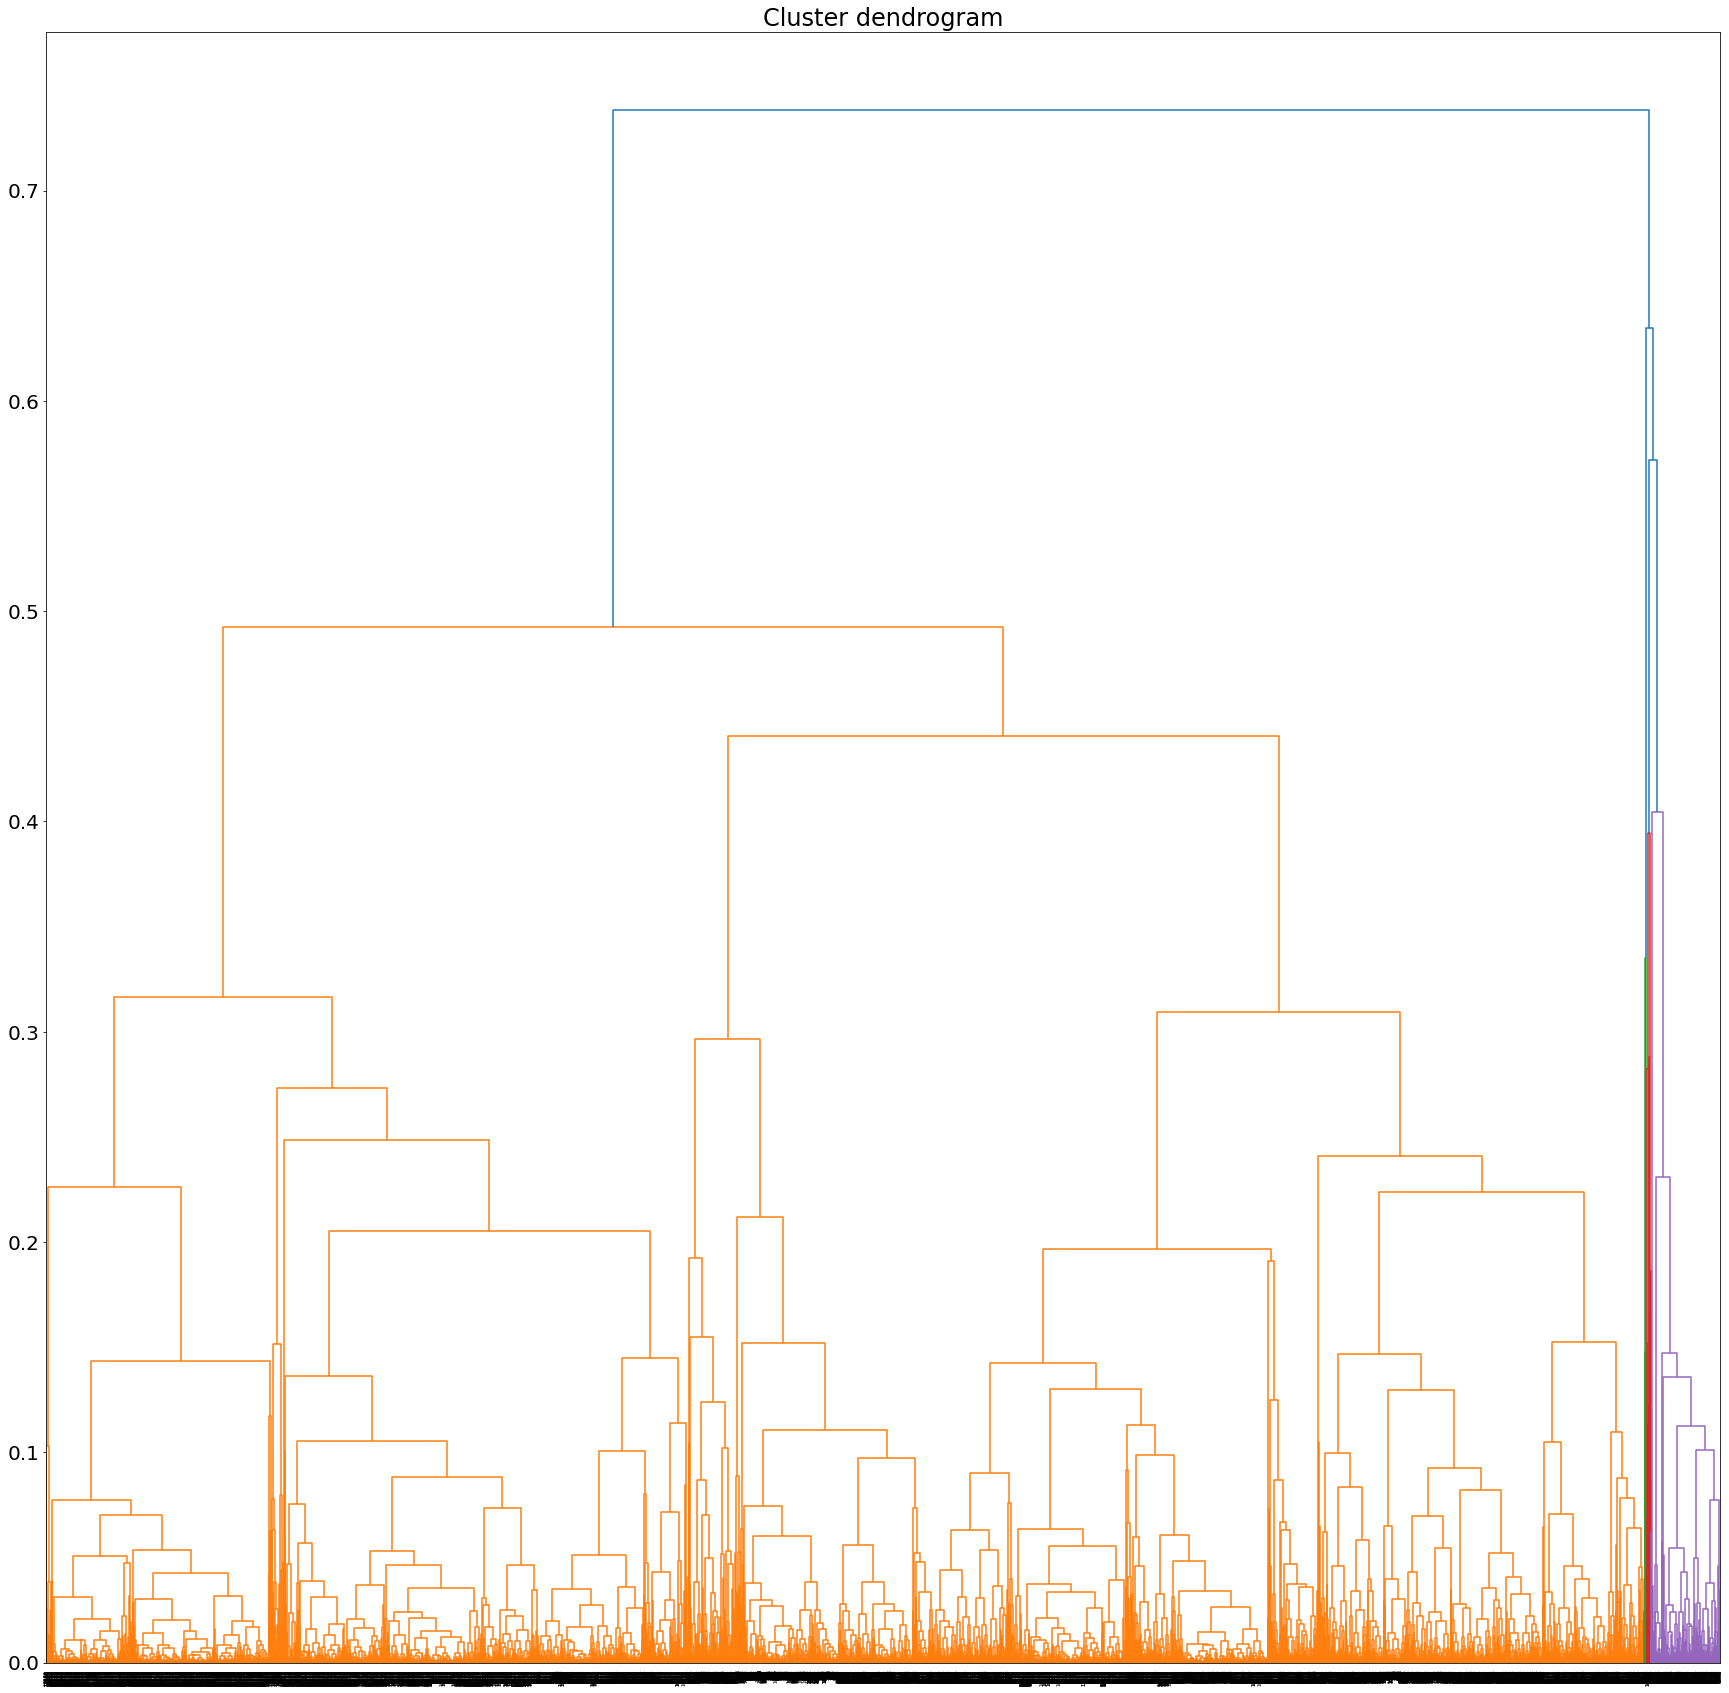

In [24]:
plt.figure(figsize = (30, 30))  
plt.title("Cluster dendrogram")  
dendo = dendrogram(df_linked)
plt.show()
plt.close()

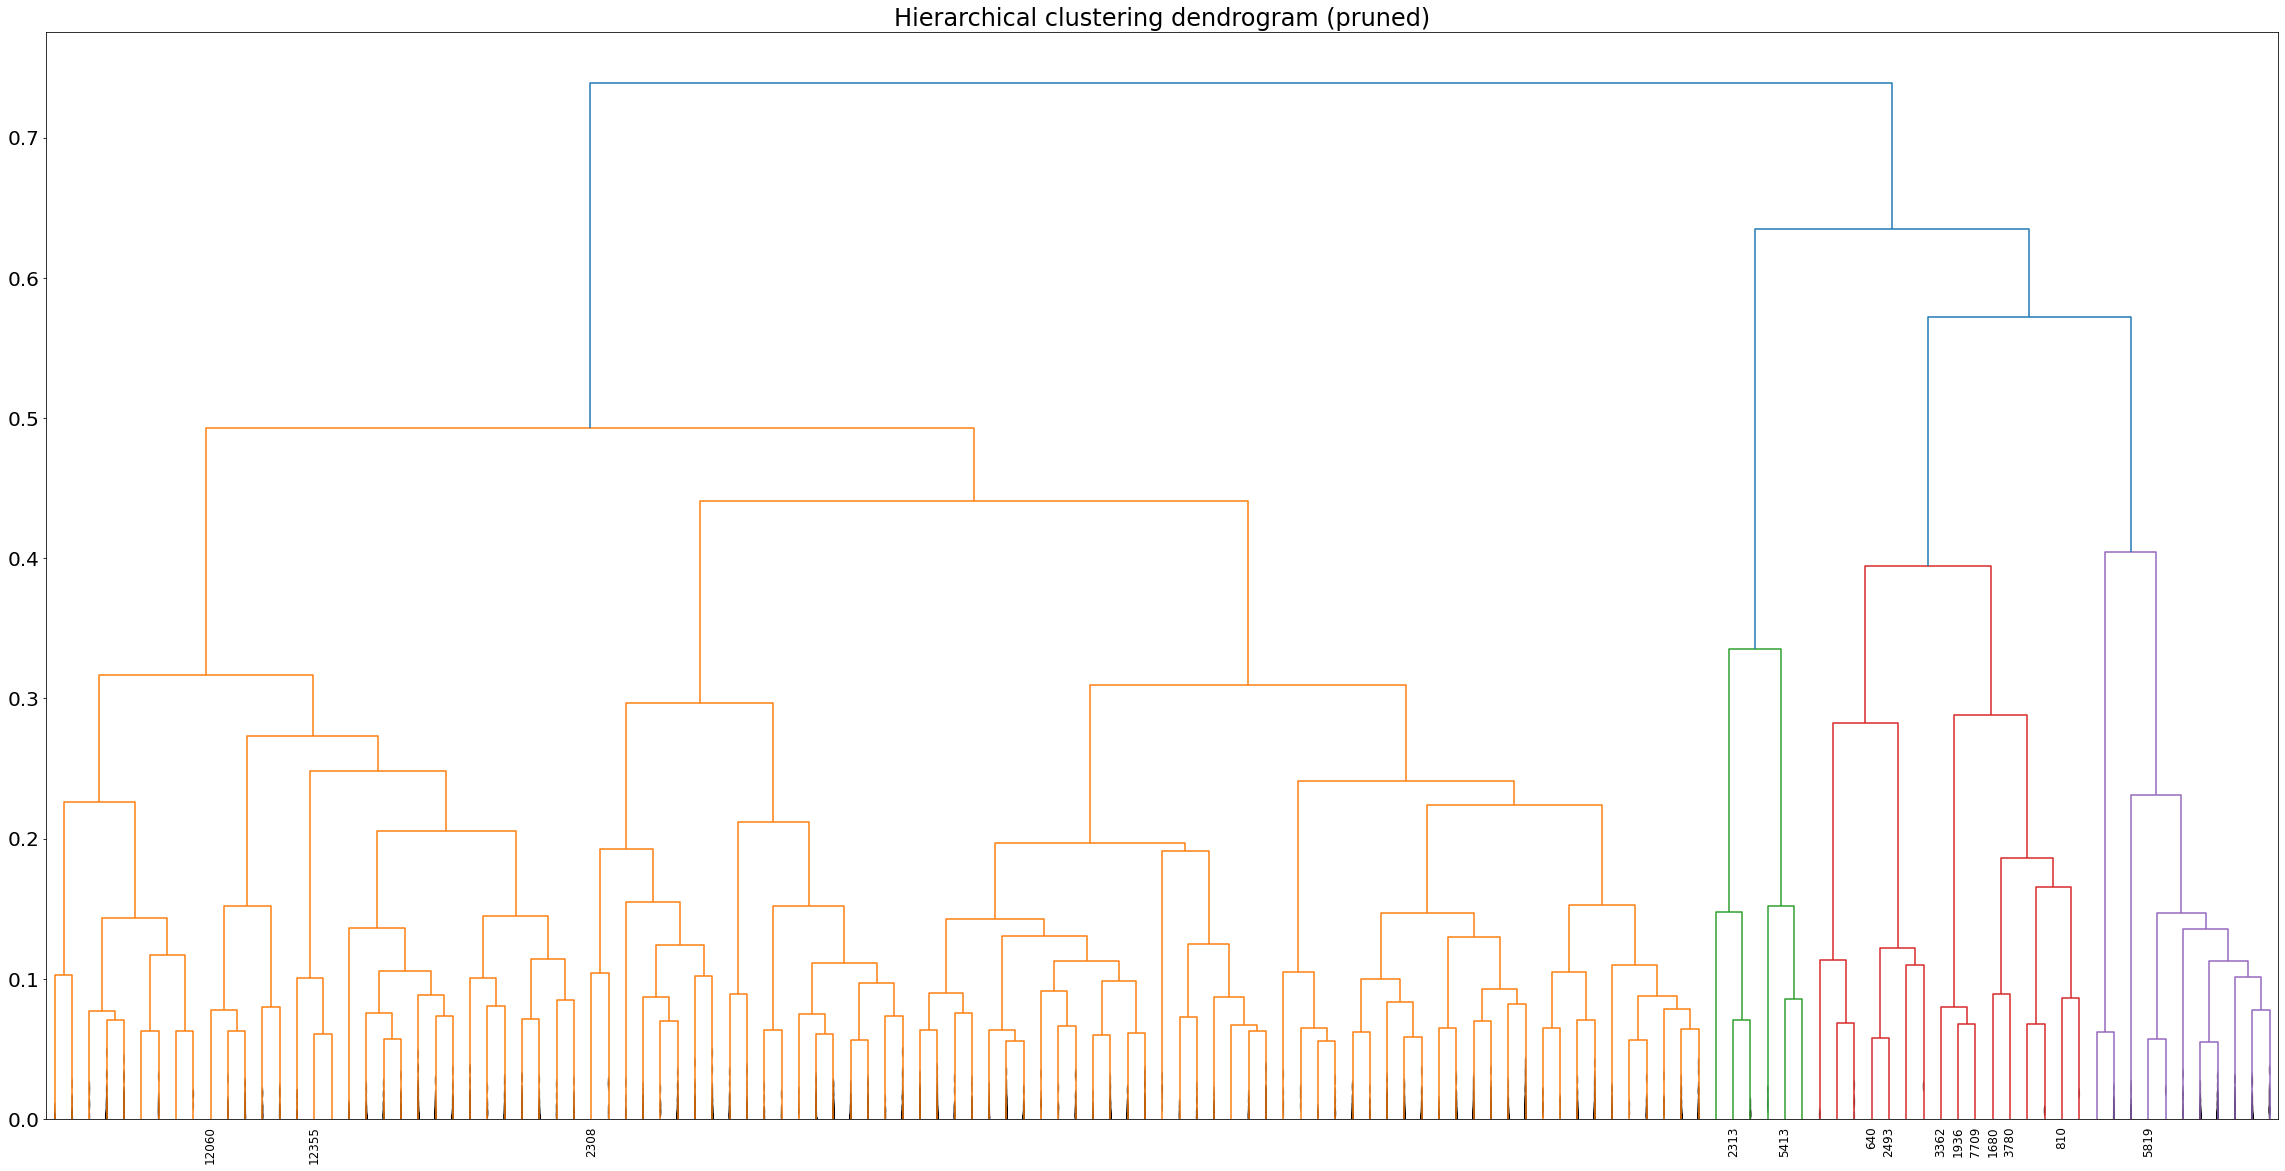

In [25]:
plt.figure(figsize=(40, 20))  
plt.title('Hierarchical clustering dendrogram (pruned)')
dendrogram(df_linked,
           truncate_mode = 'lastp',   # select truncated mode
           p = len(df_hier)/100,                    # show only last p merged clusters
           show_leaf_counts = False,  # display leaf counts
           leaf_rotation = 90,        # set the angle of leaf label rotation
           leaf_font_size = 12,       # set the font size of leaf labels 
           show_contracted = True)    # display contracted nodes
plt.show()

In [26]:
df_clusters = AgglomerativeClustering(n_clusters = 8,        # <- 2 clusters
                                      affinity = distance_metric,
                                      linkage = 'complete')  
                                         
hier_clusters = df_clusters.fit_predict(df_hier)  


In [27]:
df_hier['hier_clusters'] = hier_clusters
df['hier_clusters'] = hier_clusters

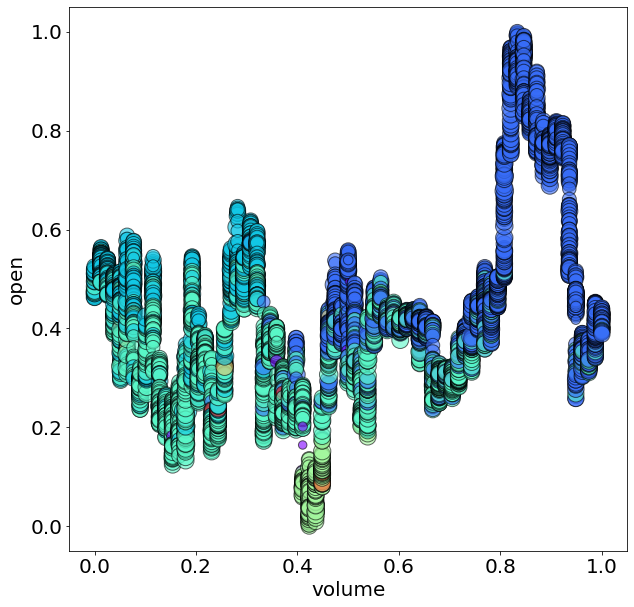

In [28]:
plot_clusters(df_hier,df_clusters,0,5,1,0,np.array(df_clusters.labels_))

x = 5
y = 1
plt.scatter(df_hier[df_hier.columns[x]],
            df_hier[df_hier.columns[y]],
            alpha = 0.4,
            c = df_clusters.labels_, s = 100*df_hier[df_hier.columns[0]],
           cmap = 'rainbow', edgecolors = 'black')
plt.xlabel(df_hier.columns[x])  
plt.ylabel(df_hier.columns[y])  
plt.show()

In [29]:
df

,date,open,close,low,high,volume,n_trades,compound_avg,compound_scaled_avg,price_change,percent_change,code,nTweets,nlikes,nreplies,nretweets,k_means_clusters,hier_clusters,db_clusters
0,2022-08-01 00:00:00,23293.82,23286.04,23262.39,23300.19,1.659310e+12,4.530644e+06,0.097517,3,-7.78,-0.03,btc,92,655,250,141,0,2,-1
1,2022-08-01 00:01:00,23292.39,23304.96,23265.66,23317.69,1.659310e+12,3.326528e+06,0.092610,3,12.57,0.05,btc,31,402,40,24,0,2,-1
2,2022-08-01 00:02:00,23305.01,23284.10,23267.89,23306.87,1.659310e+12,2.608819e+06,0.083689,3,-20.91,-0.09,btc,27,25,2,1,0,2,-1
3,2022-08-01 00:03:00,23282.13,23278.05,23264.53,23294.05,1.659310e+12,2.062340e+06,0.174514,3,-4.08,-0.02,btc,28,48,19,16,0,3,-1
4,2022-08-01 00:04:00,23275.10,23272.71,23265.08,23287.80,1.659310e+12,1.632321e+06,0.022493,3,-2.39,-0.01,btc,29,223,37,22,0,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,2022-08-09 23:55:00,23147.52,23150.23,23138.98,23155.60,1.660090e+12,1.096914e+06,0.271174,4,2.71,0.01,btc,19,6,8,7,1,3,-1
12956,2022-08-09 23:56:00,23149.45,23146.51,23143.84,23154.65,1.660090e+12,8.433827e+05,0.162300,3,-2.94,-0.01,btc,19,34,12,5,1,1,-1
12957,2022-08-09 23:57:00,23146.46,23141.24,23138.26,23147.75,1.660090e+12,9.963073e+05,0.178315,3,-5.22,-0.02,btc,20,25,12,1,1,1,-1
12958,2022-08-09 23:58:00,23142.37,23142.18,23134.09,23149.44,1.660090e+12,1.010410e+06,0.087544,3,-0.19,0.00,btc,16,20,5,3,1,1,5


In [30]:
df_hier.to_csv(output_dir+'/'+'hierarchy.csv')

In [31]:
df_hier.groupby('hier_clusters').mean().sort_values(by= 'percent_change')

,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets
hier_clusters,,,,,,,,,,,,
0,0.318912,0.215682,0.189630,0.187718,0.214093,0.350877,0.507900,0.512013,0.102820,0.026367,0.032810,0.020487
7,0.478145,0.356106,0.354182,0.363655,0.348756,0.452767,0.063083,0.582761,0.081955,0.148075,0.201806,0.599468
1,0.490719,0.551234,0.551101,0.558224,0.545893,0.763402,0.078420,0.487878,0.096571,0.010525,0.018040,0.006872
3,0.491413,0.322162,0.322259,0.329785,0.316331,0.386494,0.069879,0.567786,0.085896,0.010770,0.017748,0.006994
4,0.493374,0.076119,0.076630,0.085501,0.069354,0.433505,0.067775,0.496327,0.071239,0.007031,0.011081,0.004073
2,0.494358,0.466959,0.467434,0.472945,0.463502,0.168088,0.084061,0.456499,0.101324,0.011933,0.018712,0.007217
5,0.500565,0.368416,0.369894,0.375938,0.363331,0.312821,0.071225,0.490434,0.155238,0.252295,0.529458,0.169857
6,0.505424,0.091120,0.093527,0.101606,0.085168,0.436923,0.075801,0.223220,0.064286,0.003639,0.006098,0.002576


## DB Scan

In [32]:
df_db = cluster_scaler(2,data_dir,target_files,subset_columns,'standard')
#scatter_matrix(df_db,figsize = (20,20),diagonal='kde')

#plt.show()
#plt.close()

dbscan = DBSCAN(eps=0.9, min_samples = 8)
clusters = dbscan.fit_predict(df_db)

# Check the number of clusters
unique, counts = np.unique(clusters, return_counts=True)
print(np.asarray((unique, counts)).T)



col = df_db.columns
plt.scatter(df_db[col[4]],
            df_db[col[6]],
            alpha = 0.8,
            cmap = 'rainbow', s = 200*df_db[col[0]],
            c = clusters)
plt.xlabel(col[4])  
plt.ylabel(col[6])  
plt.show()

In [33]:
n_trainingData = 0          # amount of training data evaluated using kNNdistPlot
labels = 0                  # array containing the labels of every point on the plane
n_clusters = 0              # number of clusters


def Get_distanceMean(points,minPts,previous_distanceMean):
# points: list containing the training points you want to use
# minPts: minimum number of points to be considered a cluster
# previous_distanceMean: the previous mean of the distances
# return: average distance between the points
    if (minPts < len(points)):
        nbrs = NearestNeighbors(n_neighbors=minPts).fit(points)
        distances, indices = nbrs.kneighbors(points)
        d_mean = distances.mean()
        return d_mean
    else:
        return previous_distanceMean

In [34]:
def kNNdist_plot(points,minPts):
    epsPlot = []
    current_distanceMean = previous_distanceMean = 0
    knee_value = knee_found = 0
    count = 0
    for i in range (0,len(points),5):
        print(f'{count}: entered loop', end = ' ')

        current_distanceMean = Get_distanceMean(points[i:],minPts,previous_distanceMean)
        df = current_distanceMean - previous_distanceMean
        if ((df > 0.02) & (i > 1) & (knee_found == 0)):
            knee_value = current_distanceMean
            knee_found = 1
            n_trainingData = i
        epsPlot.append( [i,current_distanceMean] )
        previous_distanceMean = current_distanceMean
        print('leaving loop')
        count += 1

  # Plot the kNNdistPlot.
    for i in range(0, len(epsPlot)):
        plt.scatter(epsPlot[i][0],epsPlot[i][1],c='r',s=3,marker='o')
    plt.axhline(y=knee_value, color='g', linestyle='-')
    plt.axvline(x=n_trainingData , color='g', linestyle='-')
    plt.title("kNN distance")
    return plt, n_trainingData, knee_value

0: entered loop leaving loop
1: entered loop leaving loop
2: entered loop leaving loop
3: entered loop leaving loop
4: entered loop leaving loop
5: entered loop leaving loop
6: entered loop leaving loop
7: entered loop leaving loop
8: entered loop leaving loop
9: entered loop leaving loop
10: entered loop leaving loop
11: entered loop leaving loop
12: entered loop leaving loop
13: entered loop leaving loop
14: entered loop leaving loop
15: entered loop leaving loop
16: entered loop leaving loop
17: entered loop leaving loop
18: entered loop leaving loop
19: entered loop leaving loop
20: entered loop leaving loop
21: entered loop leaving loop
22: entered loop leaving loop
23: entered loop leaving loop
24: entered loop leaving loop
25: entered loop leaving loop
26: entered loop leaving loop
27: entered loop leaving loop
28: entered loop leaving loop
29: entered loop leaving loop
30: entered loop leaving loop
31: entered loop leaving loop
32: entered loop leaving loop
33: entered loop lea

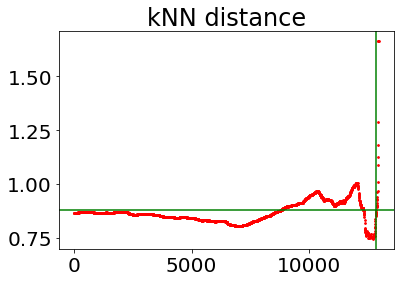

0.8786127859138064


In [35]:
plt, n_trainingData,  best_eps = kNNdist_plot(df_db, 13)
plt.show()
print(best_eps)

In [36]:
dbscan = DBSCAN(eps=best_eps
                , min_samples = 13)
db_clusters = dbscan.fit_predict(df_db)

# Check the number of clusters"
unique, counts = np.unique(db_clusters, return_counts=True)
print(np.asarray((unique, counts)).T)


[[  -1 4175]
 [   0 7755]
 [   1 1030]]


In [37]:
df['db_clusters'] = db_clusters

In [38]:
df_db['db_clusters'] = db_clusters
df_db_1 = df_db[df_db.db_clusters != -1]
opt_clusters = df_db['db_clusters']
df_db

,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets,db_clusters
date,,,,,,,,,,,,,
2022-08-01 00:00:00,-0.622791,0.290037,0.267241,0.231367,0.275239,-1.740988,1.348848,-0.122739,4.255694,0.519732,1.923588,0.323460,-1
2022-08-01 00:01:00,1.044933,0.285830,0.322908,0.240981,0.326751,-1.740988,0.630926,-0.190385,-0.048268,0.148415,-0.131523,-0.162207,0
2022-08-01 00:02:00,-1.873583,0.322960,0.261533,0.247537,0.294902,-1.740988,0.203011,-0.313347,-0.330495,-0.404891,-0.503400,-0.257679,-1
2022-08-01 00:03:00,-0.414325,0.255644,0.243732,0.237659,0.257165,-1.740988,-0.122812,0.938565,-0.259939,-0.371135,-0.337034,-0.195415,0
2022-08-01 00:04:00,-0.205860,0.234961,0.228020,0.239276,0.238768,-1.740988,-0.379199,-1.156853,-0.189382,-0.114295,-0.160882,-0.170509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-09 23:55:00,0.211071,-0.140397,-0.132348,-0.131473,-0.150369,1.733303,-0.698421,2.270891,-0.894949,-0.432776,-0.444683,-0.232774,0
2022-08-09 23:56:00,-0.205860,-0.134719,-0.143294,-0.117184,-0.153165,1.733303,-0.849583,0.770207,-0.894949,-0.391682,-0.405538,-0.241075,0
2022-08-09 23:57:00,-0.414325,-0.143516,-0.158799,-0.133590,-0.173475,1.733303,-0.758405,0.990953,-0.824393,-0.404891,-0.405538,-0.257679,0


In [39]:
import seaborn as sns


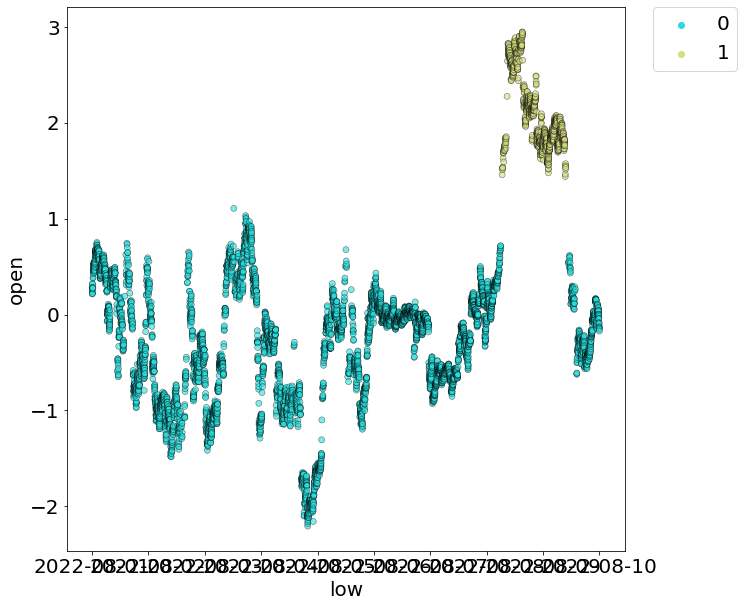

In [40]:
x = 3
y = 1
s = 0
col = df_db_1.columns

xlabel = df_db_1.columns[x]

ylabel = df_db_1.columns[y]

size_label = df_db_1.columns[s]

fig,ax = plt.subplots(figsize = (10,10))

sns.scatterplot(data = df_db_1, x = df_db_1.index ,y = ylabel,
               palette = 'rainbow', alpha = 0.6,
                hue = 'db_clusters', edgecolor="black", #s= 1000*df_db_1[size_label],
                linewidth=0.5)
               #, size = df_db['volume'])
                #, hue = df_db['n_trades'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.xlabel(xlabel)
plt.ylabel(ylabel)


plt.show()
plt.close()


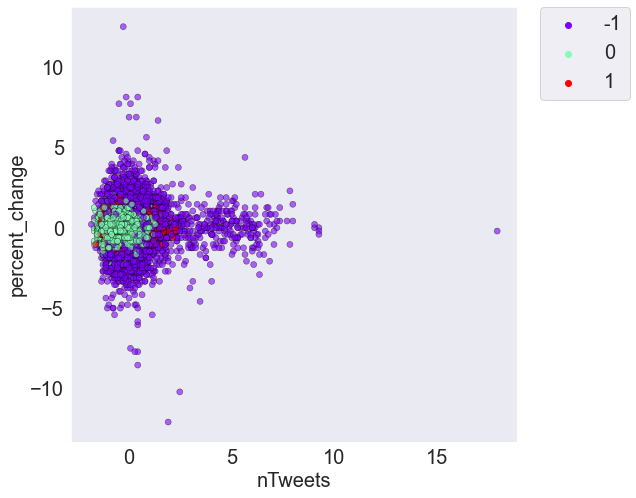

In [41]:
#import seaborn as sns
plt.figure(figsize = (8,8))
sns.set_style('dark')
#sns.color_palette("tab10")
sns.scatterplot(data = df_db, x = 'nTweets',y = 'percent_change',
               palette = 'rainbow', alpha = 0.6,
                hue = df_db['db_clusters'], edgecolor="black",
                linewidth=0.5)
               #, size = df_db['volume'])
                #, hue = df_db['n_trades'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
plt.close()

In [42]:
df_db_cluster_pc = df_db_1.groupby('db_clusters').mean().sort_values(by = ['percent_change'])


In [43]:
df_db_cluster_pc

,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets
db_clusters,,,,,,,,,,,,
0,0.022122,-0.316564,-0.315853,-0.310108,-0.322221,-0.129818,-0.361839,0.033837,-0.252050,-0.240262,-0.256124,-0.168837
1,0.047132,2.083174,2.084819,2.088936,2.078116,1.310282,-0.220123,0.024851,0.044415,-0.211526,-0.192863,-0.161997


In [44]:
df_db.groupby('db_clusters').count().sort_values(by = ['nretweets'])


,percent_change,open,close,low,high,volume,n_trades,compound_avg,nTweets,nlikes,nreplies,nretweets
db_clusters,,,,,,,,,,,,
1,1030,1030,1030,1030,1030,1030,1030,1030,1030,1030,1030,1030
-1,4175,4175,4175,4175,4175,4175,4175,4175,4175,4175,4175,4175
0,7755,7755,7755,7755,7755,7755,7755,7755,7755,7755,7755,7755


In [45]:
df_db.to_csv(output_dir+'/'+'dbscan.csv')

In [46]:
df.to_csv(output_dir+'/'+'df_post_clustering.csv')